In [287]:
#Reading the laon data from the CSV file provided

In [288]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
# Load your data

data = pd.read_csv("C://Users//kalya//Desktop//Kalyan//Upgrad AIML//Lending Club//loan//loan.csv")


### The columns with same/null values across all the fields are not needed. Dropping those unnecessary columns

In [289]:
# Dropping the columns as mentioned above
data.drop(['id', "member_id",'policy_code','acc_now_delinq', 'application_type',  'delinq_amnt'], axis = 1, inplace = True)


data.drop([ "url", "emp_title", "title", "zip_code", "last_credit_pull_d", "next_pymnt_d",
                "addr_state","desc","out_prncp_inv", "collection_recovery_fee","total_pymnt_inv","funded_amnt", "delinq_2yrs", 
                "revol_bal", "out_prncp", "total_pymnt", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
                "recoveries", "last_pymnt_d", "last_pymnt_amnt",
           "chargeoff_within_12_mths",
                "mths_since_last_delinq", "mths_since_last_record","tax_liens","initial_list_status"
           ,"collections_12_mths_ex_med","earliest_cr_line","pub_rec_bankruptcies","tax_liens","pymnt_plan","issue_d"], axis = 1, inplace = True)
data.dropna(axis = 1, how = 'all', inplace = True)



In [290]:
print(data.head)

<bound method NDFrame.head of        loan_amnt  funded_amnt_inv        term int_rate  installment grade  \
0           5000           4975.0   36 months   10.65%       162.87     B   
1           2500           2500.0   60 months   15.27%        59.83     C   
2           2400           2400.0   36 months   15.96%        84.33     C   
3          10000          10000.0   36 months   13.49%       339.31     C   
4           3000           3000.0   60 months   12.69%        67.79     B   
...          ...              ...         ...      ...          ...   ...   
39712       2500           1075.0   36 months    8.07%        78.42     A   
39713       8500            875.0   36 months   10.28%       275.38     C   
39714       5000           1325.0   36 months    8.07%       156.84     A   
39715       5000            650.0   36 months    7.43%       155.38     A   
39716       7500            800.0   36 months   13.75%       255.43     E   

      sub_grade emp_length home_ownership  an

### loan status as current is not needed for our analysis. So, removing the same

In [291]:
data = data[data.loan_status != "Current"]
data.loan_status.unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

### Cleansing the data from the required columns

In [292]:
data['revol_util'] = data['revol_util'].str.rstrip('%').astype('float') 
data['int_rate'] = data['int_rate'].str.rstrip('%').astype('float')
data['term'] = data['term'].str.extract('(\d+)').astype(float)



### replacing null values of emp_length with mode and extracting emp length 

In [293]:
data.emp_length.fillna(data.emp_length.mode()[0], inplace = True)
data.emp_length.isna().sum()
data.dropna(axis = 0, subset = ['revol_util'] , inplace = True)
data.revol_util.isna().sum()
data.emp_length = pd.to_numeric(data.emp_length.apply(lambda x: 0 if "<" in x else (x.split('+')[0] if "+" in x else x.split()[0])))


### As a next step, we need to identify and remove the outliers

<Axes: >

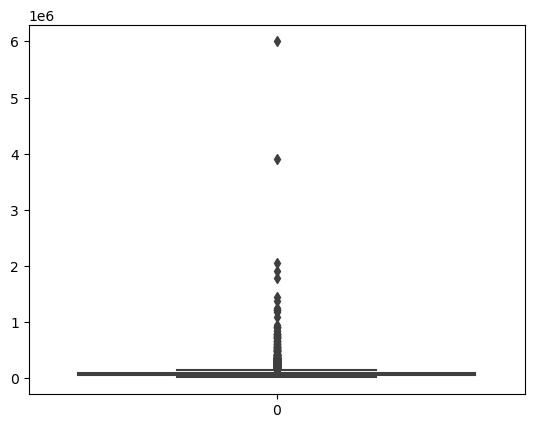

In [294]:
sns.boxplot(data['annual_inc'])

### Outliers are present. So, removing them

In [295]:
quantile_info = data.annual_inc.quantile([0.5, 0.75,0.90, 0.95, 0.97,0.98, 0.99])
quantile_info
per_95_annual_inc = data['annual_inc'].quantile(0.95)
data = data[data.annual_inc <= per_95_annual_inc]

<Axes: >

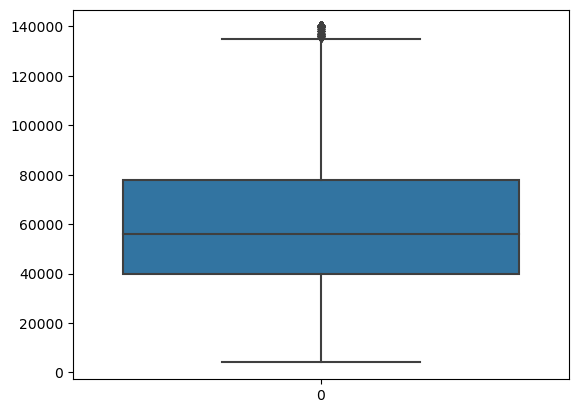

In [296]:
sns.boxplot(data['annual_inc'])

<Axes: >

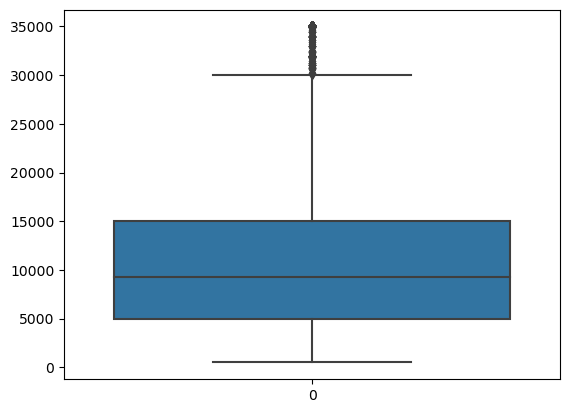

In [297]:
sns.boxplot(data.loan_amnt)

In [298]:
quantile_info = data.loan_amnt.quantile([0.5, 0.75,0.90, 0.95, 0.97,0.98, 0.99])
quantile_info
per_95_loan_amnt = data['loan_amnt'].quantile(0.95)
data = data[data.loan_amnt <= per_95_loan_amnt]

<Axes: >

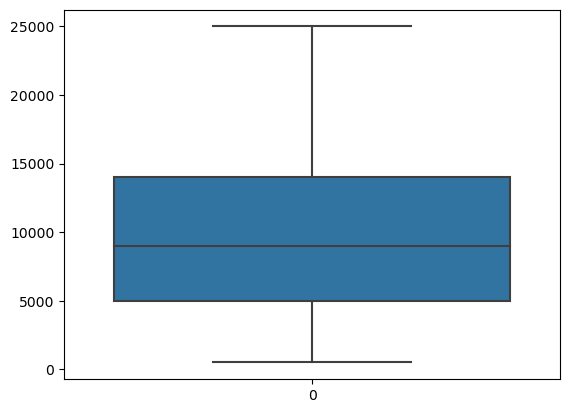

In [299]:
sns.boxplot(data.loan_amnt)

### Chart shoing the plot of data of loans that are charged off aganist grade

<Axes: xlabel='grade', ylabel='count'>

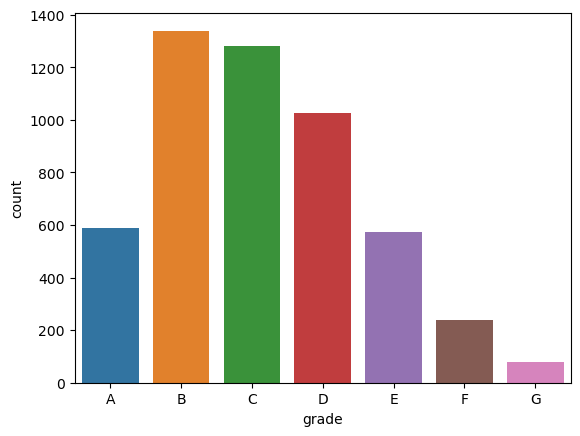

In [300]:
ax.set_title('Count of Charged Off Loans by Grade')
sns.countplot(x = 'grade', data = data[data.loan_status == 'Charged Off'], order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'])


### ploting loan status data that are charged off aganist sub grade

<Axes: title={'center': 'Count of Charged Off Loans by Sub Grade'}, xlabel='sub_grade', ylabel='count'>

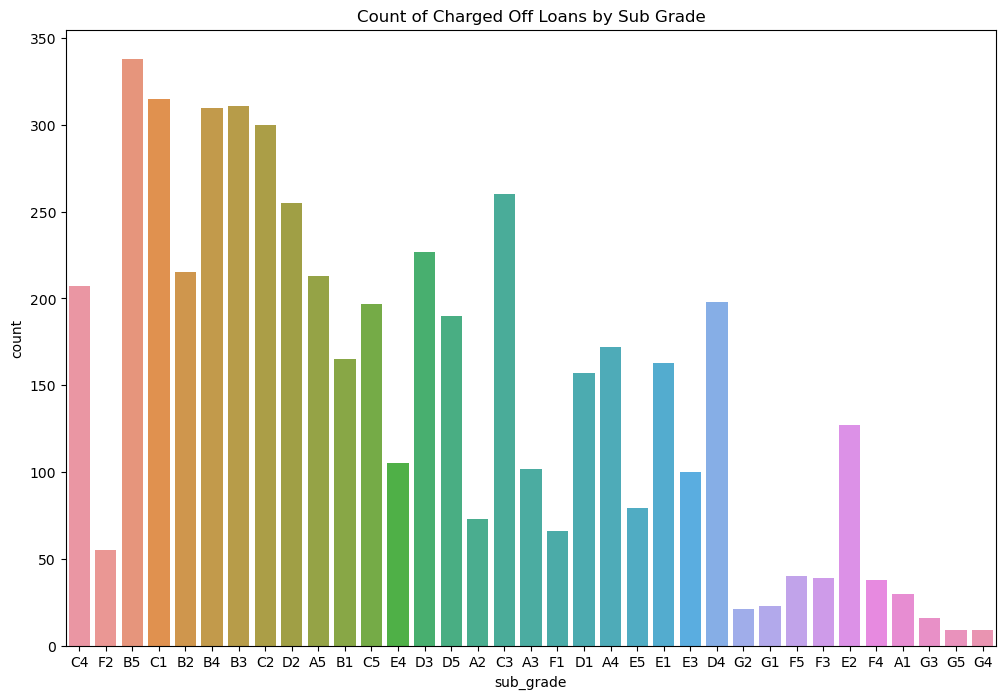

In [306]:
fig, ax = plt.subplots(figsize = (12,8))
ax.set_title('Count of Charged Off Loans by Sub Grade')
sns.countplot(x = 'sub_grade', data = data[data.loan_status == 'Charged Off'])


### ploting loan status data that are charged off aganist home ownership to find the trend

In [302]:
data['home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE'], dtype=object)

<Axes: title={'center': 'Count of Charged Off Loans by Home Ownership'}, xlabel='home_ownership', ylabel='count'>

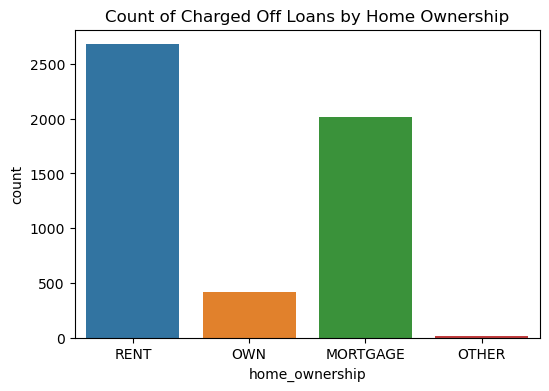

In [303]:
fig, ax = plt.subplots(figsize = (6,4))
ax.set_title('Count of Charged Off Loans by Home Ownership')
sns.countplot(x='home_ownership', data=data[data['loan_status']=='Charged Off'])

### ploting loan status data that are charged off aganist purpose

<Axes: title={'center': 'Count of Charged Off Loans by Purpose'}, xlabel='count', ylabel='purpose'>

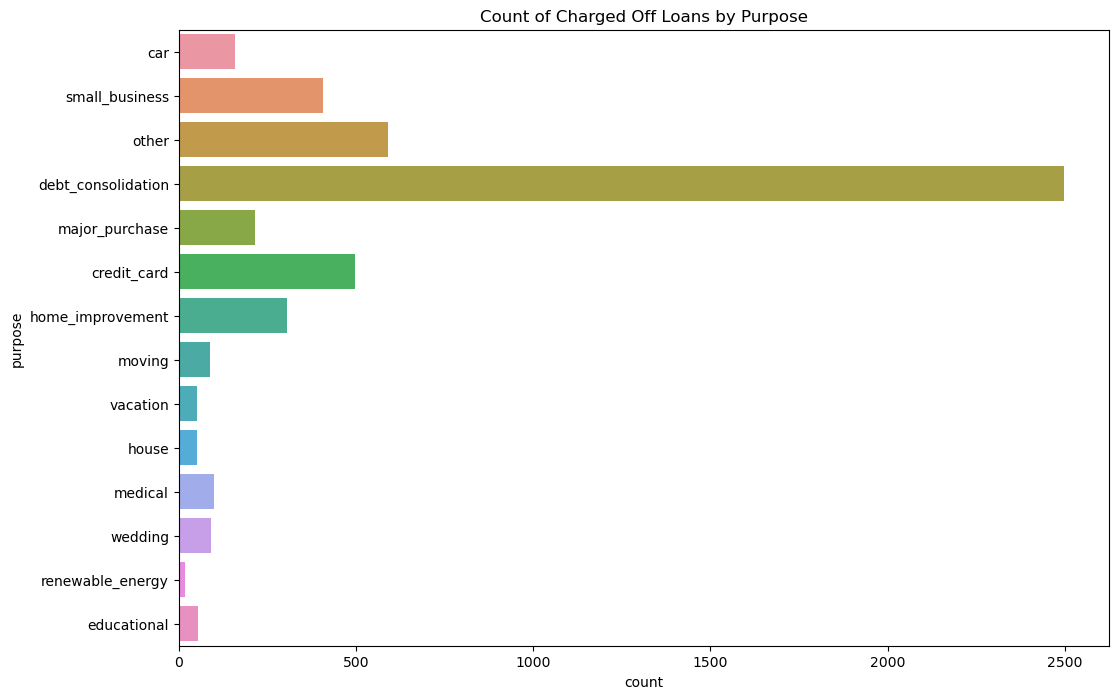

In [304]:
fig, ax = plt.subplots(figsize = (12,8))
ax.set_title('Count of Charged Off Loans by Purpose')
sns.countplot(y ='purpose', data=data[data.loan_status == 'Charged Off'])

### grouping data of intrest rate, annual income and total accounts

In [272]:
data['int_rate_groups'] = pd.cut(data['int_rate'], bins=5,precision =0,labels=['5%-10%','10%-14%','14%-18%','18%-22%','22%-24%'])
data['total_acc_groups'] = pd.cut(data['total_acc'], bins=5,precision =0,labels=['2-20','20-37','37-55','55-74','74-90'])
data['annual_inc_groups'] = pd.cut(data['annual_inc'], bins=5,precision =0,labels =['3k-30k','30k-60k','60k-85k','85k-110k','110k-140k'])
data['revol_util_groups'] = pd.cut(data['revol_util'], bins=5,precision =0,labels=['0-20','20-40','40-60','60-80','80-100'])

### ploting data of loan status which are charged off aganist revol_util_groups

<Axes: xlabel='revol_util_groups', ylabel='count'>

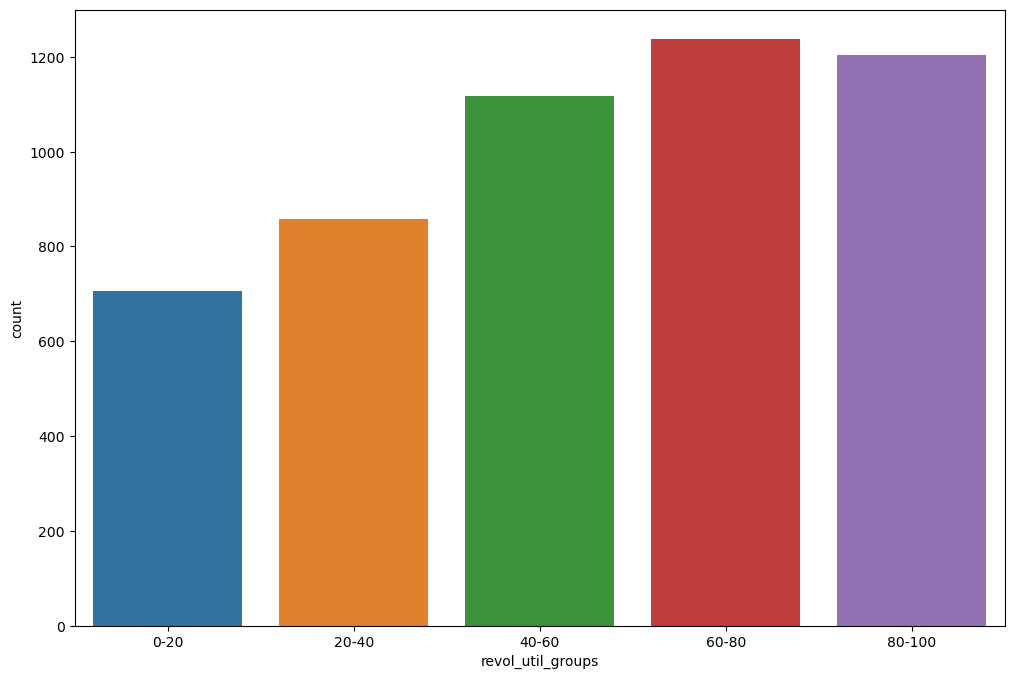

In [273]:
fig, ax = plt.subplots(figsize = (12,8))
sns.countplot(x='revol_util_groups', data=data[data.loan_status == 'Charged Off'])

### ploting data of loan status that are charged off aganist segmented interest rate 

<Axes: xlabel='int_rate_groups', ylabel='count'>

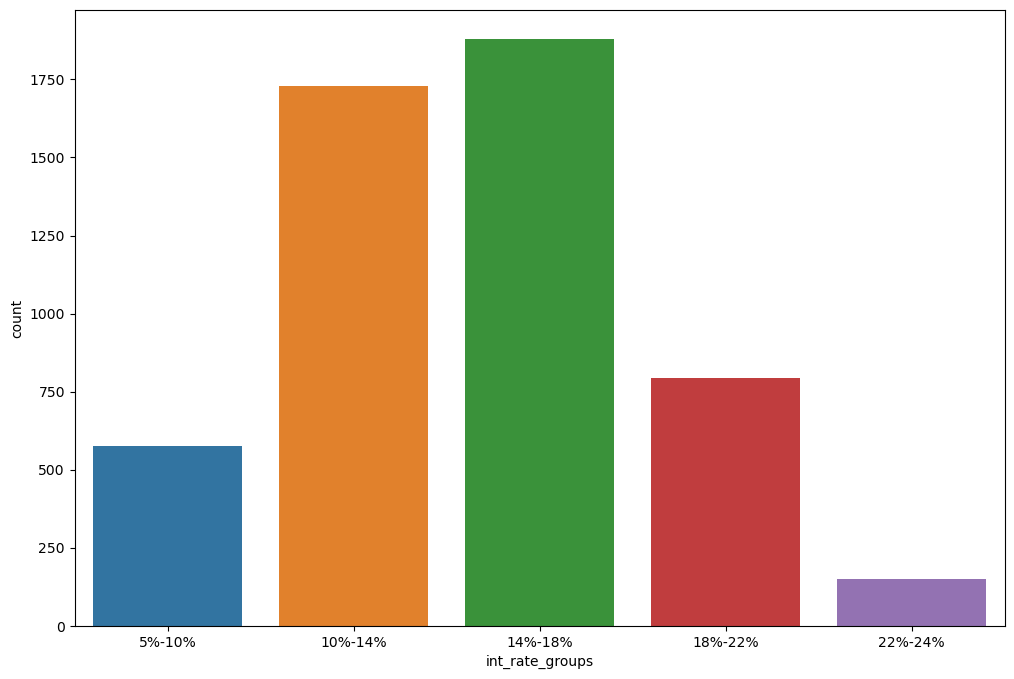

In [274]:
fig, ax = plt.subplots(figsize = (12,8))
sns.countplot(x='int_rate_groups', data=data[data.loan_status == 'Charged Off'])

### ploting loan status data that are charged off aganist annual income groups

<Axes: xlabel='annual_inc_groups', ylabel='count'>

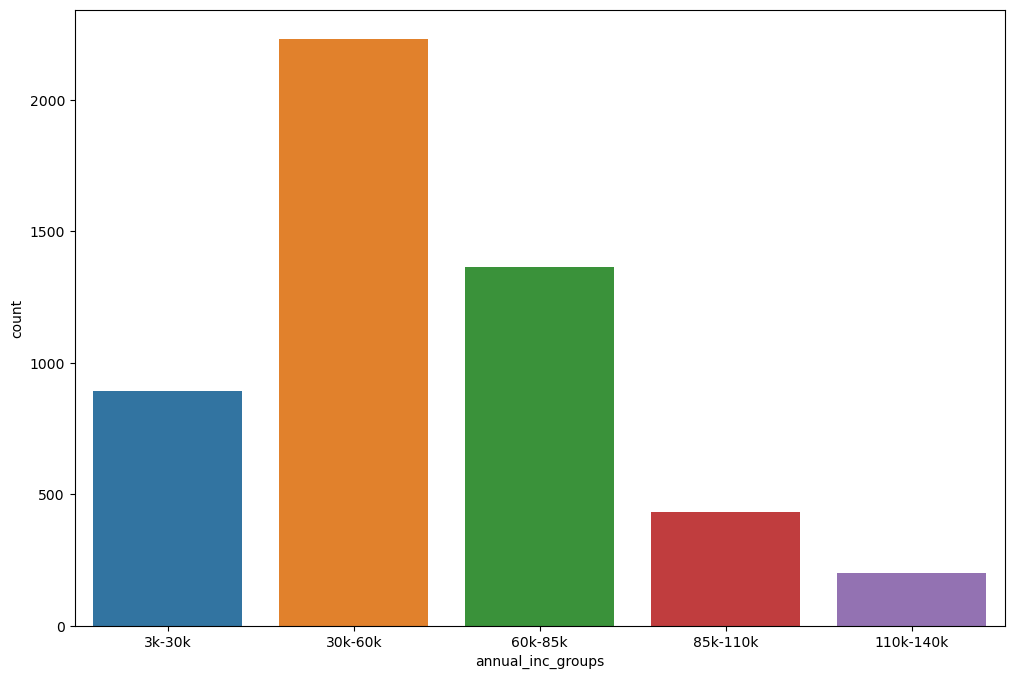

In [275]:
fig, ax = plt.subplots(figsize = (12,8))
sns.countplot(x='annual_inc_groups', data=data[data.loan_status == 'Charged Off'])

### ploting loan status data that are charged off aganist total_acc_groups

<Axes: xlabel='total_acc_groups', ylabel='count'>

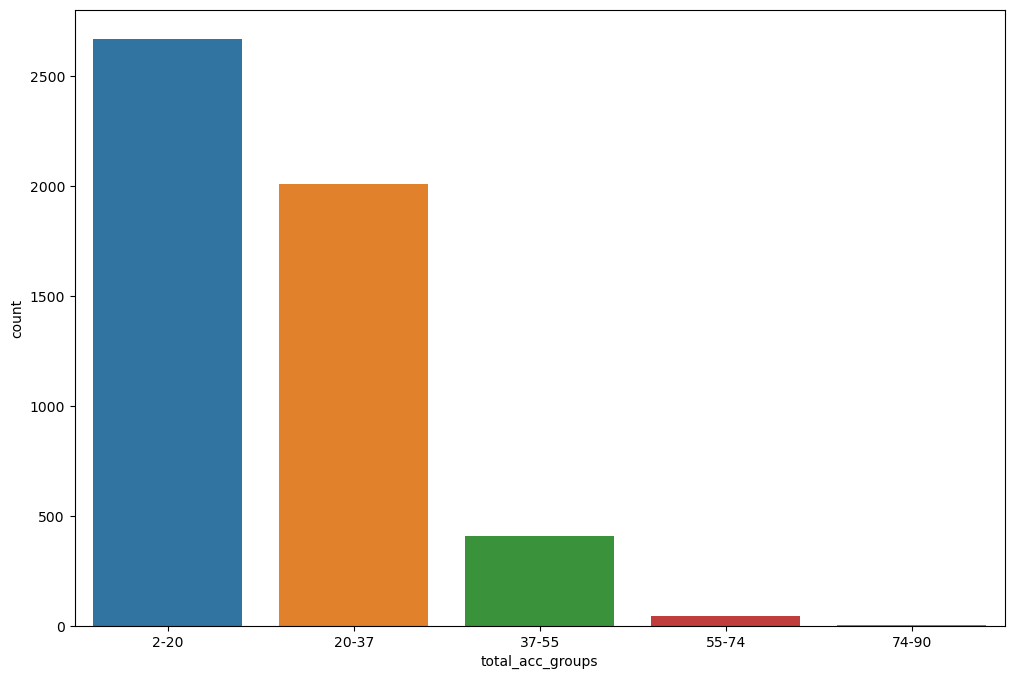

In [276]:
fig, ax = plt.subplots(figsize = (12,8))
sns.countplot(x='total_acc_groups', data=data[data.loan_status == 'Charged Off'])

### ploting data of loan status which are charged off aganist emp_length

<Axes: xlabel='emp_length', ylabel='count'>

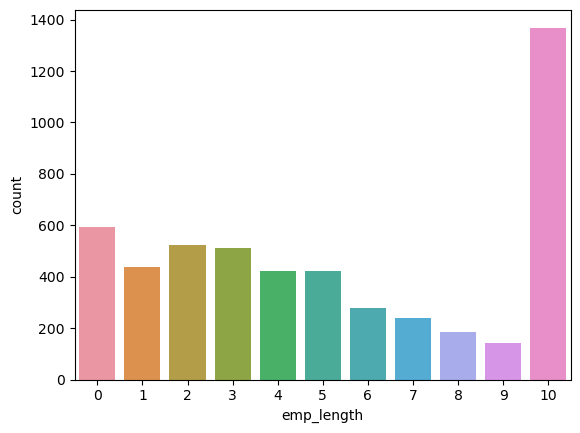

In [277]:
sns.countplot(x='emp_length', data=data[data.loan_status == 'Charged Off'])

### ploting loan status data that are charged off aganist verification_status

<Axes: xlabel='verification_status', ylabel='count'>

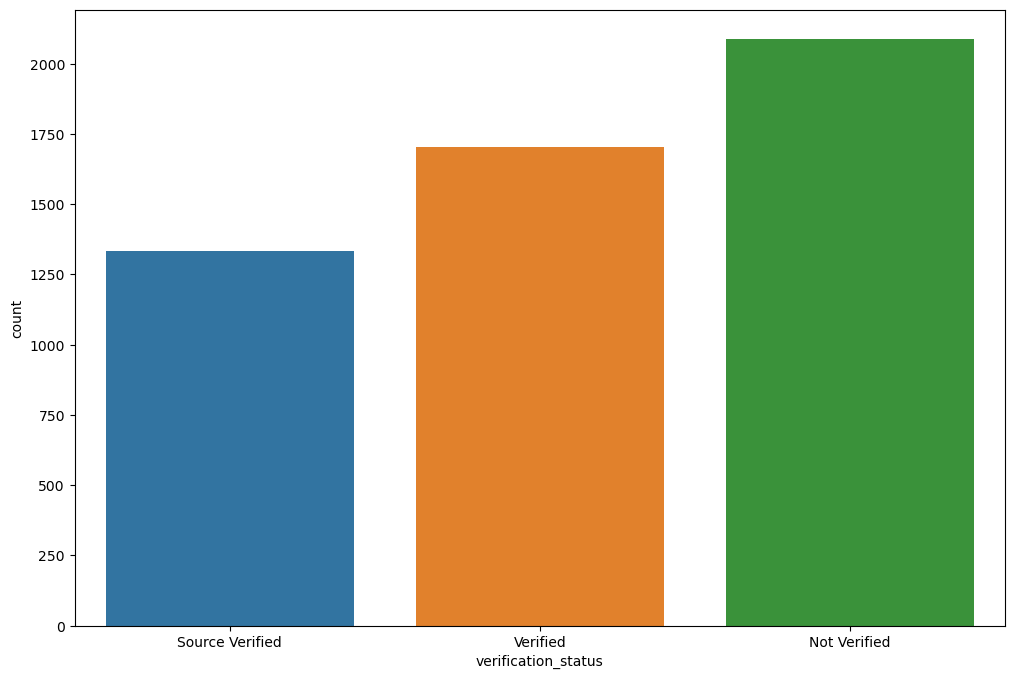

In [278]:
fig, ax = plt.subplots(figsize = (12,8))
sns.countplot(x='verification_status', data=data[data.loan_status == 'Charged Off'])

In [279]:
data.drop(["int_rate_groups","total_acc_groups","annual_inc_groups","revol_util_groups"], axis = 1, inplace = True)

In [280]:
print(data.head)

<bound method NDFrame.head of        loan_amnt  funded_amnt_inv  term  int_rate  installment grade  \
0           5000           4975.0  36.0     10.65       162.87     B   
1           2500           2500.0  60.0     15.27        59.83     C   
2           2400           2400.0  36.0     15.96        84.33     C   
3          10000          10000.0  36.0     13.49       339.31     C   
5           5000           5000.0  36.0      7.90       156.46     A   
...          ...              ...   ...       ...          ...   ...   
39711       5000            700.0  36.0      8.70       158.30     B   
39712       2500           1075.0  36.0      8.07        78.42     A   
39713       8500            875.0  36.0     10.28       275.38     C   
39714       5000           1325.0  36.0      8.07       156.84     A   
39716       7500            800.0  36.0     13.75       255.43     E   

      sub_grade  emp_length home_ownership  annual_inc verification_status  \
0            B2          10

In [281]:
grade_mapping = {'A': 8, 'B': 7, 'C': 6, 'D': 5,'D': 4,'E': 3,'F': 2,'G': 1}
data['grade'] = data['grade'].map(grade_mapping)
# Combine main grade numeric value and subgrade numeric value
#data['main_grade'] = data['sub_grade'].str.extract(r'([A-Z])')
data['subgrade_numeric'] = data['sub_grade'].str.extract(r'(\d+)').astype(float)
# Create a mapping dictionary for main grades
main_grade_mapping = {'A': 8, 'B': 7, 'C': 6, 'D': 5,'D': 4,'E': 3,'F': 2,'G': 1}
# Apply the mapping to the 'main_grade' column
# Combine main grade numeric value and subgrade numeric value
data['sub_grade'] = data['grade'] + (data['subgrade_numeric'] )
data = data.drop('subgrade_numeric', axis=1)

# Mapping for the 'home_ownership' column
home_ownership_mapping = {'RENT': 0, 'OWN': 1, 'MORTGAGE': 2, 'OTHER': 3, 'NONE': 4}

# Mapping for the 'verification_status' column
verification_status_mapping = {'Verified': 1, 'Source Verified': 2, 'Not Verified': 0}

# Apply mapping to the respective columns
data['home_ownership'] = data['home_ownership'].map(home_ownership_mapping)

# Display values that are not in the mapping dictionary
data['verification_status'] = data['verification_status'].map(verification_status_mapping)
purpose_mapping = {
    'credit_card': 1,
    'car': 2,
    'small_business': 3,
    'other': 4,
    'wedding': 5,
    'debt_consolidation': 6,
    'home_improvement': 7,
    'major_purchase': 8,
    'medical': 9,
    'moving': 10,
    'vacation': 11,
    'house': 12,
    'renewable_energy': 13,
    'educational': 14
}

# Apply mapping to the 'purpose' column (replace 'purpose' with the actual column name)
data['purpose'] = data['purpose'].map(purpose_mapping)
#data.isnull().sum()  # Check for missing values
#data = data.dropna()  # Drop rows with missing values
data = data[data['loan_status'] != 'Current']
status_mapping = {'Charged Off': 0,  'Fully Paid': 1}
data['loan_status'] = data['loan_status'].map(status_mapping)

In [282]:

y = data['loan_status']
# Separate features (X) and target variable (y)
X = data.drop('loan_status', axis=1)
# Load your data
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Train a decision tree model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top features

print(importance_df)

                Feature  Importance
16           revol_util    0.116655
12                  dti    0.115871
9            annual_inc    0.112547
3              int_rate    0.088958
17            total_acc    0.072307
4           installment    0.070493
1       funded_amnt_inv    0.069495
14             open_acc    0.069004
0             loan_amnt    0.043285
11              purpose    0.042700
7            emp_length    0.041390
6             sub_grade    0.032180
2                  term    0.028844
13       inq_last_6mths    0.027658
10  verification_status    0.021339
8        home_ownership    0.018176
5                 grade    0.016886
15              pub_rec    0.012213


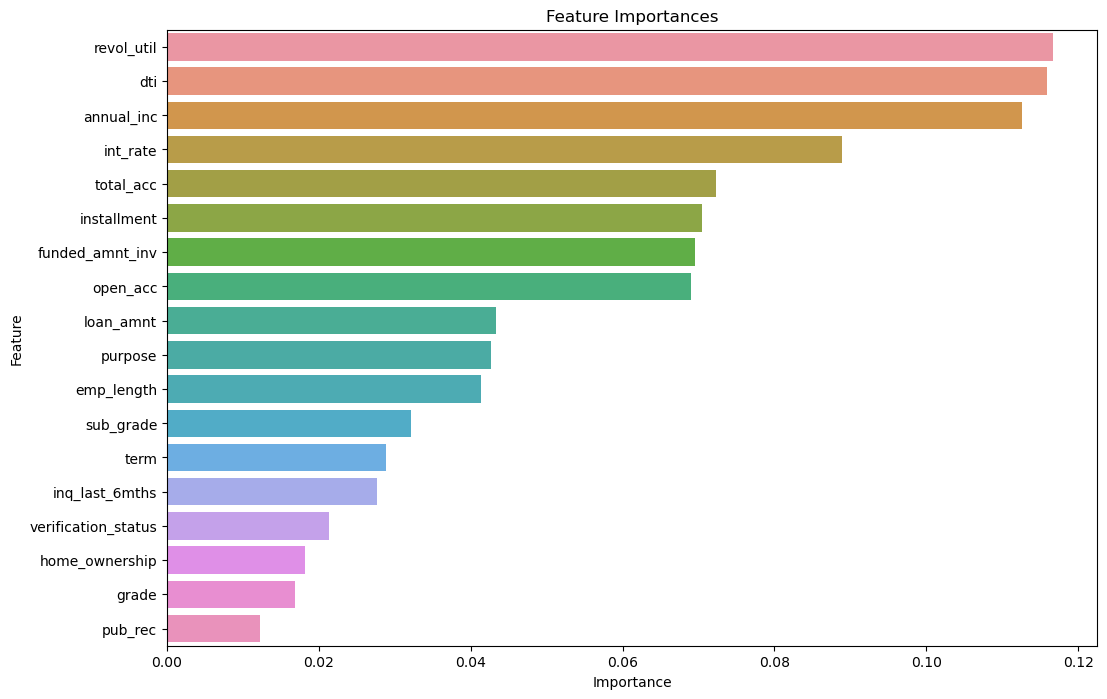

In [283]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a DataFrame named 'importance_df' with 'Feature' and 'Importance' columns
# Replace 'importance_df' with your actual DataFrame

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)

# Set plot labels and title
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')

# Show the plot
plt.show()


In [284]:


# Load your data (replace 'your_data.csv' with your actual data source)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the data into training and testing sets

# Train a Decision Tree Classifier
model = DecisionTreeClassifier(random_state=49)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display the results
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)


Accuracy: 0.7590870667793744
Confusion Matrix:
[[ 238  810]
 [ 900 5150]]
Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.23      0.22      1048
           1       0.86      0.85      0.86      6050

    accuracy                           0.76      7098
   macro avg       0.54      0.54      0.54      7098
weighted avg       0.77      0.76      0.76      7098



## From the data analysis we got below points

* Customers with verification status Not Verified tend to default more
* Customers who took the loan with purpose as Debt consolidation tend to dfault more
* Customers whose grade is B are tend to default more
* Customers whose sub grade is B5 are tend to default more
* Customers whose employment length is more than 10 years are tend to default more
* Customers whose current credit line is in between 2-20  are tend to default more
* Customers whose intrest rate is in between 14%-18%  are tend to default more
* Customers whose annual income  is in between 30k-60k  are tend to default more
* Customers whose home ownership is RENT  are tend to default more
